In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from itertools import product
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [81]:
train = pd.read_csv('train.csv')
test = pd.read_csv('testA.csv')

In [82]:
#找出对象特征和数值特征
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

In [4]:
#特征探索

In [79]:
train['annualIncome'].describe()

count    5.377280e+05
mean     7.628045e+04
std      7.291369e+04
min      0.000000e+00
25%      4.568000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annualIncome, dtype: float64

In [ ]:
cnt_srs = train['bathrooms'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.show()

In [83]:
#转化成时间格式
for data in [train, test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [84]:
#对象型特转化为数值型特征
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in (train,test):
    data['employmentLength'].replace('10+ years', '10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 year', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [85]:
#对earliesCreditLine进行预处理
train['earliesCreditLine'].sample(5)

212188    Apr-1970
299036    Mar-1996
475978    Apr-2004
588988    Mar-2001
138859    Aug-2010
Name: earliesCreditLine, dtype: object

In [86]:
for data in (train,test):
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda x : int(x[-4:]))

In [87]:
#用均方差进行异常值探索和处理

In [88]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [89]:
data_train = train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

In [90]:
#删除异常值
for fea in numerical_fea:
    train = train[data_train[fea+'_outliers']=='正常值']
    train = train.reset_index(drop=True) 

In [13]:
#创建新特征

In [91]:
#观察发现有些列的空缺值缺少比率相同，将其转化为特征
train['Missing_persent_5'] = train['n14'].apply(lambda x:1 if x>0 else 0)
train['Missing_persent_4'] = train['n10'].apply(lambda x:1 if x>0 else 0)
test['Missing_persent_5'] = test['n14'].apply(lambda x:1 if x>0 else 0)
test['Missing_persent_4'] = test['n10'].apply(lambda x:1 if x>0 else 0)

In [92]:
for col in ['grade', 'subGrade']: 
    temp_dict = train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    train[col + '_target_mean'] = train[col].map(temp_dict)
    test[col + '_target_mean'] = test[col].map(temp_dict)

In [93]:
#创造一个年收入和每年还款金额的比例，可以预期的是这个比例越大，越不容易违约
train['income_repay_percent'] = train['annualIncome'] / ((train['loanAmnt'] * train['interestRate'] * train['term'] + train['loanAmnt']) / train['term'])
test['income_repay_percent'] = test['annualIncome'] / ((test['loanAmnt'] * test['interestRate'] * test['term'] + test['loanAmnt']) / test['term'])

In [94]:
#创造一个借款人剩余贬损公共记录的数量
train['last_pubRec'] = train['pubRec'] - train['pubRecBankruptcies']
test['last_pubRec'] = test['pubRec'] - test['pubRecBankruptcies']

In [18]:
#进行特征筛选


In [19]:
corrs = train.corr()

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [20]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  11


In [21]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)


In [22]:
train['issueDate'] = train['issueDate'].astype(np.int64)
test['issueDate'] = test['issueDate'].astype(np.int64)

In [23]:
#建模预测

In [24]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

In [24]:
#LGB模型模拟
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['id']
    test_ids = test_features['id']
    
    # Extract the labels for training
    labels = features['isDefault']
    
    # Remove the ids and target
    features = features.drop(columns = ['id', 'isDefault'])
    test_features = test_features.drop(columns = ['id'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=2000, objective = 'binary', num_leaves = 14,max_depth = 4,
                                   class_weight = 'balanced',min_child_weight=5, learning_rate = 0.1, 
                                   reg_alpha = 9.58, reg_lambda = 4.62, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 400, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submit = pd.DataFrame({'id': test_ids, 'isDefault': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submit, feature_importances, metrics

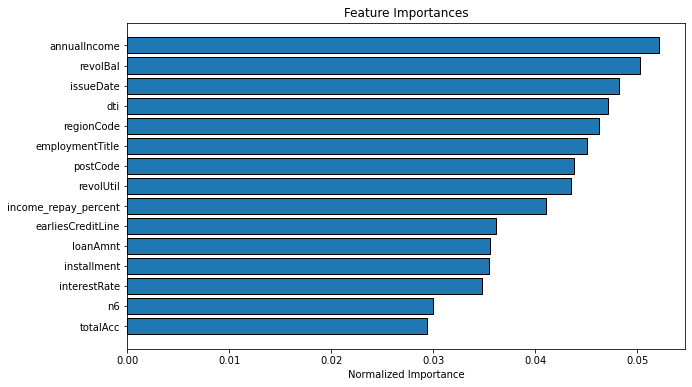

In [55]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)

In [ ]:
#网格搜索调参

In [25]:
from sklearn.model_selection import GridSearchCV

X_train = train.drop(columns=['id', 'isDefault'])
y_train = train['isDefault']
X_train = pd.get_dummies(X_train)

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, min_child_samples=21,param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_child_weight=min_child_weight,
                                   min_child_samples=min_child_samples,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [28]:
#调整max_depth 和 num_leaves
param_grid = {
    'max_depth': [4,5,6,8],
    'num_leaves': [20,30,40]
}
get_best_cv_params(max_depth = None,
                   num_leaves = None,
                   learning_rate = 0.1,
                   feature_fraction = 0.7,
                   min_child_samples=21,
                   min_child_weight=0.001,
                   bagging_fraction = 1,
                   bagging_freq = 2,
                   reg_alpha = 9.58,
                   reg_lambda = 4.62,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be igno

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be igno

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be igno

In [31]:
#调整min_data_in_leaf 和 min_sum_hessian_in_leaf   
#该步骤主要是防止树过拟合
param_grid = {
'min_child_samples': [28,29,30,31,32],
'min_child_weight': [0.001,0.002]
}
get_best_cv_params(max_depth = 4,
                   num_leaves = 20,
                   learning_rate = 0.1,
                   feature_fraction = 0.6,
                   min_child_samples=18,
                   min_child_weight=0.001,
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = 10,
                   reg_lambda = 6,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )                    

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [30]:
#调整feature_fraction
param_grid = {
'feature_fraction': [0.6, 0.8, 1],
}
get_best_cv_params(max_depth = 4,
                   num_leaves = 20,
                   learning_rate = 0.1,
                   feature_fraction = None,
                   min_child_samples=19,
                   min_child_weight=0.001,
                   bagging_fraction = 1,
                   bagging_freq = 2,
                   reg_alpha = 9.58,
                   reg_lambda = 4.62,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )            

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be igno

In [31]:
#调整bagging_fraction和bagging_freq
param_grid = {
'bagging_fraction': [0.8,0.9,1],
'bagging_freq': [2,3,4],
}
get_best_cv_params(max_depth = 4,
                   num_leaves = 20,
                   learning_rate = 0.1,
                   feature_fraction = 0.6,
                   min_child_samples=18,
                   min_child_weight=0.001,
                   bagging_fraction = None,
                   bagging_freq = None,
                   reg_alpha = 9.58,
                   reg_lambda = 4.62,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )    

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

In [27]:
#调整reg_alpha和reg_lambda
param_grid = {
'reg_alpha': [8,9,10],
'reg_lambda': [4,5,6],
}
get_best_cv_params(max_depth = 4,
                   num_leaves = 20,
                   learning_rate = 0.1,
                   feature_fraction = 0.6,
                   min_child_samples=18,
                   min_child_weight=0.001,
                   bagging_fraction = 0.9,
                   bagging_freq = 3,
                   reg_alpha = None,
                   reg_lambda = None,
                   n_estimators = 1000,
                   min_split_gain = 0,
                   param_grid=param_grid
                  )    

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [52]:
#lgb模型模拟
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    
    #Extract the ids
    train_ids = features['id']
    test_ids = test_features['id']
    
    # Extract the labels for training
    labels = features['isDefault']
    
    # Remove the ids and target
    features = features.drop(columns = ['id', 'isDefault'])
    test_features = test_features.drop(columns = ['id'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=4000, 
                                   objective = 'binary', 
                                   num_leaves = 20,
                                   max_depth = 4,
                                   class_weight = 'balanced',
                                   min_child_weight=0.001,
                                   min_child_samples=29,
                                   feature_fraction = 0.6,
                                   learning_rate = 0.05, 
                                   bagging_fraction = 0.9,
                                   bagging_freq = 3,
                                   reg_alpha = 10, 
                                   reg_lambda = 6,
                                   n_jobs = -1, 
                                   random_state = 50,
                                   min_split_gain = 0)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 400, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submit = pd.DataFrame({'id': test_ids, 'isDefault': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submit, feature_importances, metrics

In [53]:
submit,fi,metrics = model(train,test)

Training Data Shape:  (537728, 92)
Testing Data Shape:  (200000, 92)
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 400 rounds
[200]	train's auc: 0.730463	train's binary_logloss: 0.606461	valid's auc: 0.724953	valid's binary_logloss: 0.61064
[400]	train's auc: 0.737408	train's binary_logloss: 0.600697	valid's auc: 0.729119	valid's binary_logloss: 0.606844
[600]	train's auc: 0.742217	train's binary_logloss: 0.596675	valid's auc: 0.7314	valid's binary_logloss: 0.604074
[800]	train's auc: 0.746191	train's binary_logloss: 0.593382	valid's auc: 0.732718	valid's binary_logloss: 0.6025
[1000]	train's auc: 0.749693	train's binary_logloss: 0.590455

[3200]	train's auc: 0.777538	train's binary_logloss: 0.566412	valid's auc: 0.733457	valid's binary_logloss: 0.593104
Early stopping, best iteration is:
[2961]	train's auc: 0.775029	train's binary_logloss: 0.568577	valid's auc: 0.733532	valid's binary_logloss: 0.593832
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 400 rounds
[200]	train's auc: 0.730113	train's binary_logloss: 0.606594	valid's auc: 0.725791	valid's binary_logloss: 0.610831
[400]	train's auc: 0.737311	train's binary_logloss: 0.60067	valid's auc: 0.729794	valid's binary_logloss: 0.606628
[600]	train's auc: 0.742112	train's binary_logloss: 0.596703	valid's auc: 0.731746	valid'

In [66]:
submit.to_csv('submit13.csv', index=False)